In [46]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings("ignore")

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [47]:
raw_data = pd.read_csv('data/epi_r.csv')

In [48]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [49]:
raw_data.shape

(20052, 680)

In [50]:
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
raw_data['title'].head()

0                Lentil, Apple, and Turkey Wrap 
1    Boudin Blanc Terrine with Red Onion Confit 
2                  Potato and Fennel Soup Hodge 
3               Mahi-Mahi in Tomato Olive Sauce 
4                      Spinach Noodle Casserole 
Name: title, dtype: object

In [52]:
# check which column has null value
raw_data.isnull().sum()[raw_data.isnull().sum()>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [53]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [54]:
raw_data['rating'].value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

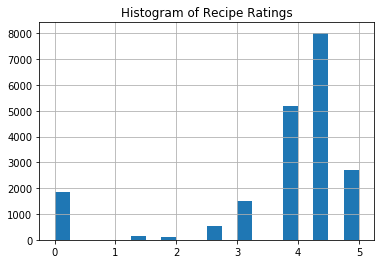

In [55]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [56]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [14]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

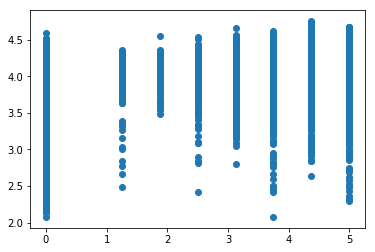

In [61]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [62]:
svr.score(X, Y)

0.03856570651298896

In [63]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([0.01818511, 0.026411  , 0.03037705, 0.01957949, 0.02451197])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

In [57]:
# check the unique values in each column
raw_data.nunique().sort_values(ascending=False)

title                 17736
sodium                 2434
calories               1858
fat                     326
protein                 282
rating                    8
fourth of july            2
fritter                   2
frittata                  2
friendsgiving             2
freezer food              2
freeze/chill              2
frankenrecipe             2
frangelico                2
france                    2
fontina                   2
fortified wine            2
food processor            2
fruit                     2
florida                   2
flat bread                2
flaming hot summer        2
fish                      2
fig                       2
frozen dessert            2
game                      2
fruit juice               2
fry                       2
grappa                    2
grapefruit                2
                      ...  
orzo                      2
organic                   2
oregon                    2
oregano                   2
orange juice        

As shown above, we can see that most of the columns has binary value, corresponding to whether a specific recipe has that feature or not. This time we will keep the numeric features that have more than 2 unique values to potentially increase our model prediction

Since we are converting the problem into binary classification problem, we will separate the `rating` column into two groups, first we will examine the distribution of each rating and set up a cutoff value

In [58]:
# examine the distribution
raw_data['rating'].value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

We can see that there are around 10K examples that are above 4 points, we will choose 4 as a cutoff

In [59]:
# separate the rating column into two groups, high and low
raw_data['rating'] = np.where(raw_data['rating'] > 4, 'High', 'Low')

In [60]:
# check the result
raw_data['rating'].value_counts()

High    10738
Low      9314
Name: rating, dtype: int64

Before fitting into our model, we will do some preprocessing such as imputing and scaling

In [61]:
# import imputer for numeric columns and impute missing values with mean
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
imputer = SimpleImputer()

# import StandardScaler to normalize the column
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

In [62]:
# first we split the raw data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw_data.drop('rating', axis=1), raw_data['rating']
                                                    ,test_size=0.3, random_state=1009, stratify=raw_data['rating'])

In [63]:
# define customed imputer, incorporate scaler as well
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

class CustomQuantitativeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean', scale=True):
        self.strategy = strategy
        self.scale = scale
    def transform(self, df):
        num = ['calories', 'protein', 'fat', 'sodium']
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        X[num] = impute.fit_transform(X[num])
        if self.scale:
            scaler = StandardScaler()
            X[num] = scaler.fit_transform(X[num])
            return X.drop(['title'], axis=1)
        else:
            return X.drop(['title'], axis=1)
    def fit(self, *_):
        return self
    def get_params(self, deep=True):
        return {"strategy": self.strategy, 'scale': self.scale}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    

In [64]:
X_train.head()

,title,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
11334,Ginger Marmalade Chicken Salad,451.0,56.0,10.0,162.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12796,Pork Fricassée with Mushrooms and Carrots,728.0,41.0,54.0,375.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12325,Barbecue Chicken Pizza,809.0,47.0,35.0,1541.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11501,Macaroni and Cheese with Prosciutto and Taleggio,776.0,32.0,43.0,1120.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3456,"Peach, Plum and Blackberry Cobbler",421.0,5.0,16.0,168.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will then build a pipeline to incorporate the our custimize imputer and scaler `CustomQuantitativeImputer` as well as the `LinearSVC` model, we will do the grid search to find out the best hyperparameters

In [65]:
# build a pipeline, incorporate gridsearch for imputing method, scale or not scale, as well as feature selection
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
pipe = Pipeline([
       ('impute_and_scale', CustomQuantitativeImputer()),
       ('classifier', lsvc)
])

params = ({
    'impute_and_scale__strategy': ['mean', 'median'],
    'impute_and_scale__scale': [False, True],
    'classifier__C': [0.001, 0.01, 1, 10, 100],
    
})

# use gridsearch to find the best parameters 
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid=params, cv=5)
grid.fit(X_train, y_train)

# print out the best parameters and best score
print('Best parameters: {}'.format(grid.best_params_))
print('Best scores: {}'.format(grid.best_score_))

Best parameters: {'classifier__C': 0.001, 'impute_and_scale__scale': True, 'impute_and_scale__strategy': 'mean'}
Best scores: 0.5919777714448561


After found out the best parameters, we will use the parameters on our training and test set

In [66]:
# apply the customize imputer on our train and test set
cqi = CustomQuantitativeImputer(strategy='mean', scale=True)
X_train_lsvc = cqi.fit_transform(X_train)
X_test_lsvc = cqi.transform(X_test)

In [67]:
# examine the result
print(X_train_lsvc.isnull().sum().sum())
print(X_test_lsvc.isnull().sum().sum())

0
0


Our next step is to determine feature importance, we will use the random forest model so see which features are more important than others and select the top 30 for our model use

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train_lsvc.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

In [33]:
feature_importances

,importance
calories,0.051726
sodium,0.049180
fat,0.041713
protein,0.038319
quick & easy,0.011857
bon appétit,0.010072
gourmet,0.009470
summer,0.009239
bake,0.008377
winter,0.008191


We will incorporate different number of features from the table shown above to determine the best score

Score of 4 features: 0.5354801937874039
Score of 10 features: 0.5558563693359931
Score of 20 features: 0.5604873183243089
Score of 30 features: 0.5681818181818182
Score of 50 features: 0.5779424337418068
Score of 100 features: 0.5919777714448561
Score of 200 features: 0.6021658592191508
Score of 300 features: 0.6047306925049871
Score of 500 features: 0.6077229980051296
Score of 678 features: 0.6079367341122827


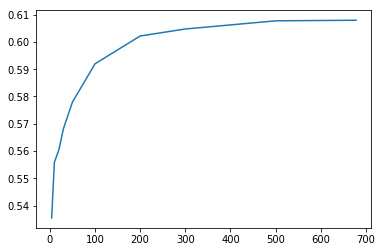

In [70]:
lsvc = LinearSVC(C=0.001)
x_point = [4, 10, 20, 30, 50, 100, 200, 300, 500, 678]
y_point = []
for i in x_point:
    important = feature_importances.head(i).index
    lsvc.fit(X_train_lsvc[important], y_train)
    y_point.append(lsvc.score(X_train_lsvc[important], y_train))
    print('Score of {} features: {}'.format(i, lsvc.score(X_train_lsvc[important], y_train)))
plt.plot(x_point, y_point)

From the graph above we can see that around 200 features the score has reached around the plate, we will use the top 200 features as our final parameters for our test set

In [73]:
# applying our parameters on the test set
lsvc = LinearSVC(C=0.001)
important = feature_importances.head(200).index
lsvc.fit(X_test_lsvc[important], y_test)
print('Final score on test set: {}'.format(lsvc.score(X_test_lsvc[important], y_test)))

Final score on test set: 0.6095412234042553


In [74]:
# find out the base score
y_test.value_counts(normalize=True)

High    0.535572
Low     0.464428
Name: rating, dtype: float64

We can see that our base score to beat is 53.56% and we get a score around 60.95%, next we will try other svc model that use the non-linear kernel like Gaussian kernel for further improvement

In [75]:
from sklearn.svm import SVC
svc = SVC()
pipe = Pipeline([
       ('impute_and_scale', CustomQuantitativeImputer()),
       ('classifier', svc)
])

params = ({
    'impute_and_scale__strategy': ['mean', 'median'],
    'impute_and_scale__scale': [False, True],
    'classifier__C': [0.001, 0.01, 1, 10, 100],
    
})

# use gridsearch to find the best parameters 
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid=params, cv=5)
grid.fit(X_train, y_train)

# print out the best parameters and best score
print('Best parameters: {}'.format(grid.best_params_))
print('Best scores: {}'.format(grid.best_score_))

Best parameters: {'classifier__C': 100, 'impute_and_scale__scale': True, 'impute_and_scale__strategy': 'median'}
Best scores: 0.5987460815047022


In [76]:
# use the best parameters to processs training and testing examples
cqi2 = CustomQuantitativeImputer(strategy='median', scale=True)
X_train_svc = cqi2.fit_transform(X_train)
X_test_svc = cqi2.transform(X_test)

Score of 4 features: 0.5355514391564549
Score of 10 features: 0.5604873183243089
Score of 20 features: 0.5936164149330293
Score of 30 features: 0.6251068680535765
Score of 50 features: 0.6694214876033058
Score of 100 features: 0.7143060701054431
Score of 200 features: 0.7140923339982901
Score of 300 features: 0.6881590196637218
Score of 500 features: 0.6690652607580507
Score of 678 features: 0.658520946138501


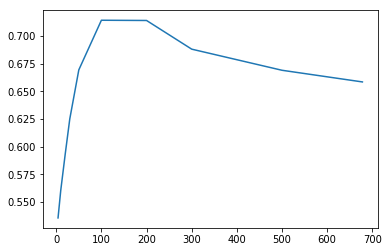

In [78]:
svc = SVC(C=100)
x_point = [4, 10, 20, 30, 50, 100, 200, 300, 500, 678]
y_point = []
for i in x_point:
    important = feature_importances.head(i).index
    svc.fit(X_train_svc[important], y_train)
    y_point.append(svc.score(X_train_svc[important], y_train))
    print('Score of {} features: {}'.format(i, svc.score(X_train_svc[important], y_train)))
plt.plot(x_point, y_point)

From the graph above, it seems that the non-linear kernel works the best when we include top 100 features, we will further use for our test set.

In [79]:
# applying our parameters on the test set
svc = SVC(C=100)
important = feature_importances.head(100).index
svc.fit(X_test_svc[important], y_test)
print('Final score on test set: {}'.format(svc.score(X_test_svc[important], y_test)))

Final score on test set: 0.7616356382978723


We have further improved our model by using Gaussian kernel and we reached the accuracy score of 76.16%, which is better than our previous record 60.95%!